# Practical Machine Learning for Physicists
## Week 6 Exercise 
## Deadline Monday 30th November at 12pm (Noon)

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$ 


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$ 
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where 
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Import tqdm for progress bar
from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Exercises: Predicting Chaos

### Setting up functions:

In [2]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's

In [3]:
def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2
    

In [4]:
def shapeArray(x, windowsize, offset):
    ''' This function splits up a 1-d array x into a series of overlapping windows
    The return is a tuple of the array of input windows and target (label) windows'''
    xInput = np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize+offset)+1)])
    xLabel = np.array([x[i +windowsize : i+ windowsize+offset] for i in range(len(x)-(windowsize+offset)+1)])
    return (xInput,xLabel)

In [5]:
def motion(z0, t0, tmax, dt):
    ''' Function to solve the pendulum differential equation for initial condition z0, from time t0 to tmax
    Returns:
    Cartesian coordinate arrays and time array'''
    
    # Set up the initial conditions. Here we have lengths and masses and gravitational acceleration
    L1, L2 = 1., 1.
    m1, m2 = 3., 1.
    g = 9.81     
    
    # Create time array
    t = np.arange(t0, tmax+dt, dt)
    
    # Solve initial value problem
    ret = solve_ivp(rhs, (t0-1,tmax+1), z0, t_eval = t, args =(L1, L2, m1, m2, g))
    z = ret.y

    # Extract result
    theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)
    
    return (x1,y1,x2,y2), t

In [6]:
def predict_motion(model, x1, y1, x2, y2, steps, windowsize, offset):
    '''Function to predict the motion into future for given window size and offset'''
    
    # Compile given model to ensure model is untrained
    model.compile(loss='mean_squared_error',optimizer='adam')
    
    # Stack coordinates such that we have an array of the coordinate of all coordinates at each time step
    xy = np.stack((x1,y1,x2,y2), axis = 1)
    
    # Reshape the data into (batchsize, timesteps, data)
    xyInput, xyLabel = shapeArray(xy, windowsize, offset)
    
    # Create training sample only including up to t0( windowsize*dt)
    xyTrain  = xyInput[:windowsize]
    
    # Create training target only including up to t0( windowsize*dt), and last time step in label batch
    xyTarget = xyLabel[:windowsize,-1]

    # Array for plotting cost
    costs = np.zeros(steps)  
    
    for i in tqdm(range(steps)):   
        # Train the network on batches
        costs[i] = model.train_on_batch( xyTrain, xyTarget ) 
    
    # Test data includes whole data range beyond window size
    xyTest = xyInput
    
    # Predicts futures using Test data
    xy_hat = model.predict_on_batch(xyTest)
    
    # Retrieve predicted coordinates from predicted array
    x1_hat, y1_hat = xy_hat[:,0], xy_hat[:,1]
    x2_hat, y2_hat = xy_hat[:,2], xy_hat[:,3]
    
    return costs, (x1_hat, y1_hat, x2_hat, y2_hat)

In [7]:
def cost_plot(costs, steps, x1, y1, x2, y2, x1_hat, y1_hat, x2_hat, y2_hat):   
    ''' Function to plot predicted trajectories and cost function'''
    
    # Setting up subplot
    fig,ax=plt.subplots(1,2, figsize=(15,5))
    
    # Plot costs vs steps
    ax[0].plot(np.arange(steps), costs, label=r"Costs")
    
    # Plot labels and title
    ax[0].set_xlabel("Steps")
    ax[0].set_ylabel("Cost")
    ax[0].set_title("Network Training Cost")

    # Plot for trajectories of true motion and predicted
    ax[1].plot(x1,y1,label=r"$x1y1_{True}$")
    ax[1].plot(x2,y2,label=r"$x2y2_{True}$")
    ax[1].plot(x1_hat,y1_hat,label=r"$x1y1_{Prediction}$")
    ax[1].plot(x2_hat,y2_hat,label=r"$x2y2_{Prediction}$")
    
    # Plot labels, title and legend
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")
    ax[1].set_title("Network Prediction")
    ax[1].legend()
    
    plt.show()

In [8]:
def motion_plot(x1, y1, x2, y2, x1_hat, y1_hat, x2_hat, y2_hat, t, windowsize, offset, xlims):
    
    ''' Function to plot coordinate trajectories against time'''
    
    # Setting up subplot
    fig, ax=plt.subplots(4,1, figsize=(15,10))
    fig.suptitle(r'Plot of coordinates for offset of t0+ $\delta${0}'.format(offset))

    # Plot x1 true and predicted coordinates
    ax[0].plot(t,x1,label=r"$x1_{True}$")
    ax[0].plot(t[windowsize+offset-1:],x1_hat,label=r"$x1_{Prediction}$")
    # Set x limits
    ax[0].set_xlim(xlims[0],xlims[1])
    # Plot labels, titles and legend
    ax[0].set_xlabel("t")
    ax[0].set_ylabel("x1")
    ax[0].set_title("Network Prediction x1")
    ax[0].legend()

    # Plot x2 true and predicted coordinates
    ax[1].plot(t,x2,label=r"$x2_{True}$")
    ax[1].plot(t[windowsize+offset-1:],x2_hat,label=r"$x2_{Prediction}$")
    # Set x limits
    ax[1].set_xlim(xlims[0],xlims[1])
    # Plot labels, titles and legend
    ax[1].set_xlabel("t")
    ax[1].set_ylabel("x2")
    ax[1].set_title("Network Prediction x2")
    ax[1].legend()

    # Plot y1 true and predicted coordinates
    ax[2].plot(t,y1,label=r"$y1_{True}$")
    ax[2].plot(t[windowsize+offset-1:],y1_hat,label=r"$y1_{Prediction}$")
    # Set x limits
    ax[2].set_xlim(xlims[0],xlims[1])   
    # Plot labels, titles and legend
    ax[2].set_xlabel("t")
    ax[2].set_ylabel("y1")
    ax[2].set_title("Network Prediction y1")
    ax[2].legend()

    # Plot y2 true and predicted coordinates
    ax[3].plot(t,y2,label=r"$y2_{True}$")
    ax[3].plot(t[windowsize+offset-1:],y2_hat,label=r"$y2_{Prediction}$")
    # Set x limits
    ax[3].set_xlim(xlims[0],xlims[1])    
    # Plot labels, titles and legend
    ax[3].set_xlabel("t")
    ax[3].set_ylabel("y2")
    ax[3].set_title("Network Prediction y2")
    ax[3].legend()
    
    # Adjust spacing
    plt.subplots_adjust(hspace = 0.7)
    plt.show()

In [9]:
def chi(model, predict_motion, x1, y1, x2, y2, windowsizes, offsets):
    ''' Function to calculate chi squared/ sum of square deviations of given model predictions 
    as they vary with offsets in offset array; uses given predictive motion function'''
    
    # Initialise array to hold chi squared values
    chi_sq = np.zeros([len(offsets),4])
    
    # Loop over offsets array
    for i in range(len(offsets)):
        # Set window size and offset
        windowsize = 100
        offset     = offsets[i]
        
        # Predict motio using function
        costs, (x1_hat, y1_hat, x2_hat, y2_hat) = predict_motion(model, x1, y1, x2, y2, steps, windowsize, offset)
        
        # Calculate chi squared for each coordinate
        chi_x1 = np.sum((x1[windowsize+offset-1:]-x1_hat)**2)#/x1[windowsize+offset-1:])
        chi_x2 = np.sum((x2[windowsize+offset-1:]-x2_hat)**2)#/x1[windowsize+offset-1:])
        chi_y1 = np.sum((y1[windowsize+offset-1:]-y1_hat)**2)#/x2[windowsize+offset-1:])
        chi_y2 = np.sum((y2[windowsize+offset-1:]-y2_hat)**2)#/y2[windowsize+offset-1:])
        
        # Store chi values
        chi_sq[i] = np.array([chi_x1, chi_x2, chi_y1, chi_y2])
        
    return chi_sq

In [10]:
def chi_plot(offsets, chi_sq):
    '''Function to plot chi squared over different offsets '''
    
    # Creates subplot
    fig, ax=plt.subplots(1,1, figsize=(15,5))

    # Plot each chi square for each coordinate
    ax.plot(offsets,chi_sq[:,0],label=r"$x_1$")
    ax.plot(offsets,chi_sq[:,1],label=r"$x_2$")
    ax.plot(offsets,chi_sq[:,2],label=r"$y_1$")
    ax.plot(offsets,chi_sq[:,3],label=r"$y_2$")
    
    # Set titles, labels and legend
    ax.set_xlabel("Offset value")
    ax.set_ylabel("Chi Squared value")
    ax.set_title("Network Prediction y2")
    ax.legend()

    plt.show()

## Part 1:
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 

In [11]:
# Define model with LSTM layer of 50, with 4 cartesian coordinate input and output 
model=keras.models.Sequential()
model.add(keras.layers.LSTM(50, input_shape=(None,4),return_sequences=False)) # LSTM layer with 50 neurons
model.add(keras.layers.Dense(4, activation="linear"))

# Compiling the model
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11000     
_________________________________________________________________
dense (Dense)                (None, 4)                 204       
Total params: 11,204
Trainable params: 11,204
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Time ranges and set values
t0, tmax, dt = 0, 50, 0.1
        
#Starting angles
z0 = [np.pi/4,0,np.pi/4,0]

# Create arrays for pedulum motion for z0 = [np.pi/4,0,np.pi/4,0]
(x1,y1,x2,y2), t = motion(z0, t0, tmax, dt)

In [13]:
# Number of samples we will use to train our network
windowsize= 100

# How many samples into the future to predict
offset= 20

# Number of training steps
steps = 400    

# Predicts future motion using function
costs, (x1_hat, y1_hat, x2_hat, y2_hat) = predict_motion(model, x1, y1, x2, y2, steps, windowsize, offset)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.87it/s]


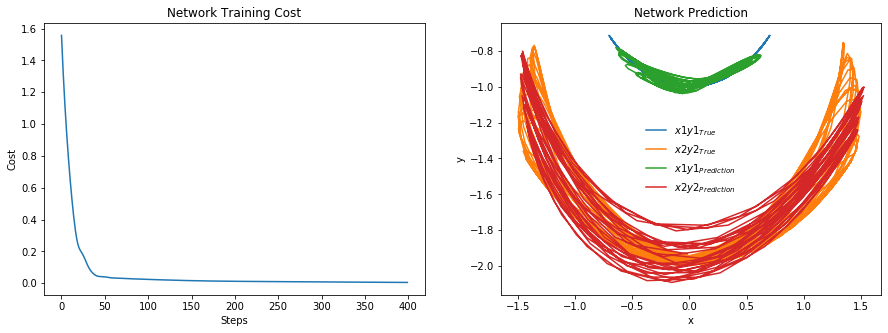

Final cost is 0.004738926887512207


In [14]:
# Plot future trajectories and cost
cost_plot(costs, steps, x1, y1, x2, y2, x1_hat, y1_hat, x2_hat, y2_hat)
print('Final cost is',costs[-1])

## Part 2:
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp

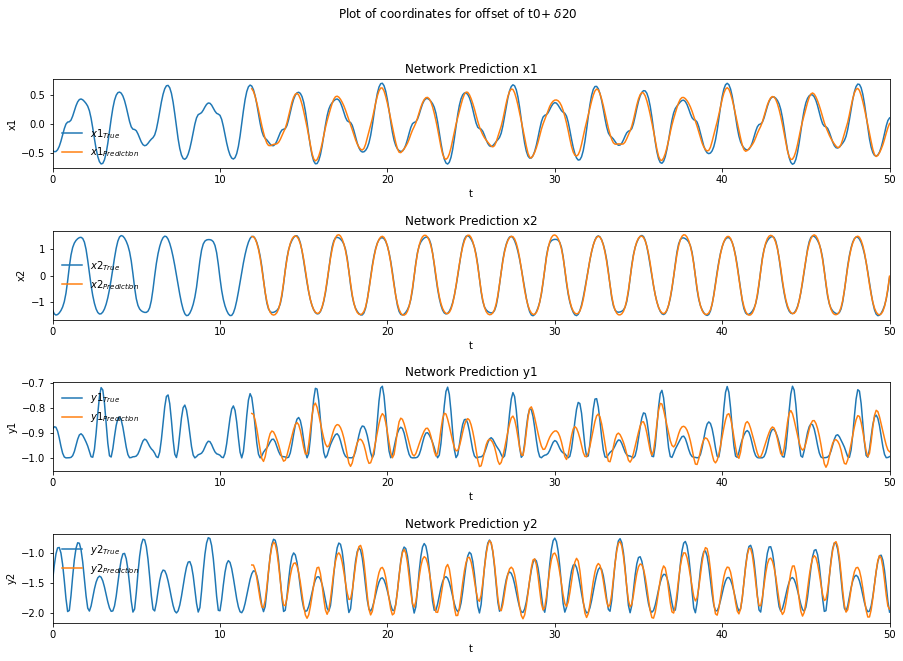

In [15]:
# Set plot limits 
xlims = (0,50)

# Plot motion of each coordinate in time
motion_plot(x1, y1, x2, y2, x1_hat, y1_hat, x2_hat, y2_hat, t, windowsize, offset, xlims)

### Comment:
- We see that the prediction is stable for more periodic motions, as the the predictions follow the trajectory $t_0$ into the future after the offset. The network learns from the timesteps before $t_0$ this means for periodic functions in the training set is a good approximation for the function over the whole time, where as for more chaotic motion the data is less periodic and future extrapolations become hard to predict with the same start window

## Part 3: 
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:29<00:00, 13.35it/s]


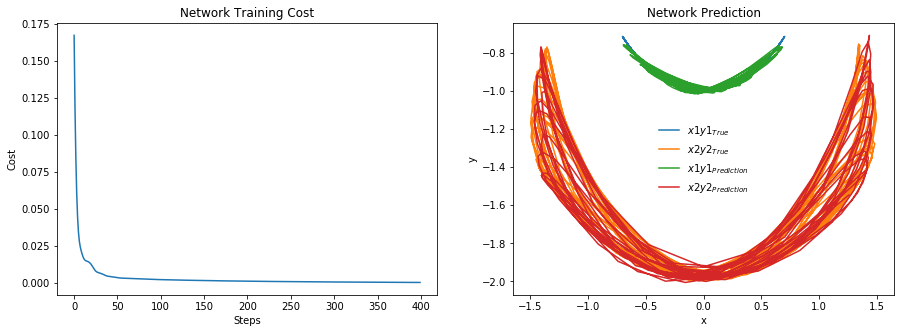

Final cost is 0.0004889257252216339


In [16]:
# New offset to predict 100 into future
windowsize1= 100
offset1= 100

# Predicts future motion using function
costs2, (x1_hat2, y1_hat2, x2_hat2, y2_hat2) = predict_motion(model, x1, y1, x2, y2, steps, windowsize1, offset1)
# Plot future trajectories and cost
cost_plot(costs2, steps, x1, y1, x2, y2, x1_hat2, y1_hat2, x2_hat2, y2_hat2)
print('Final cost is',costs2[-1])

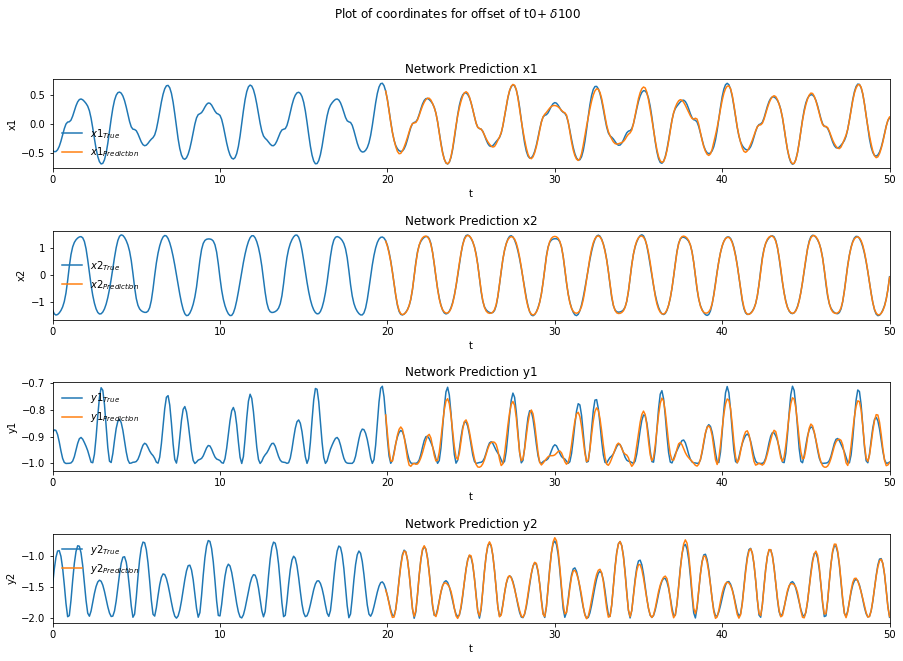

In [17]:
# Set plot limits 
xlims = (0,50)

# Plot motion of each coordinate in time
motion_plot(x1, y1, x2, y2, x1_hat2, y1_hat2, x2_hat2, y2_hat2, t, windowsize1, offset1, xlims)

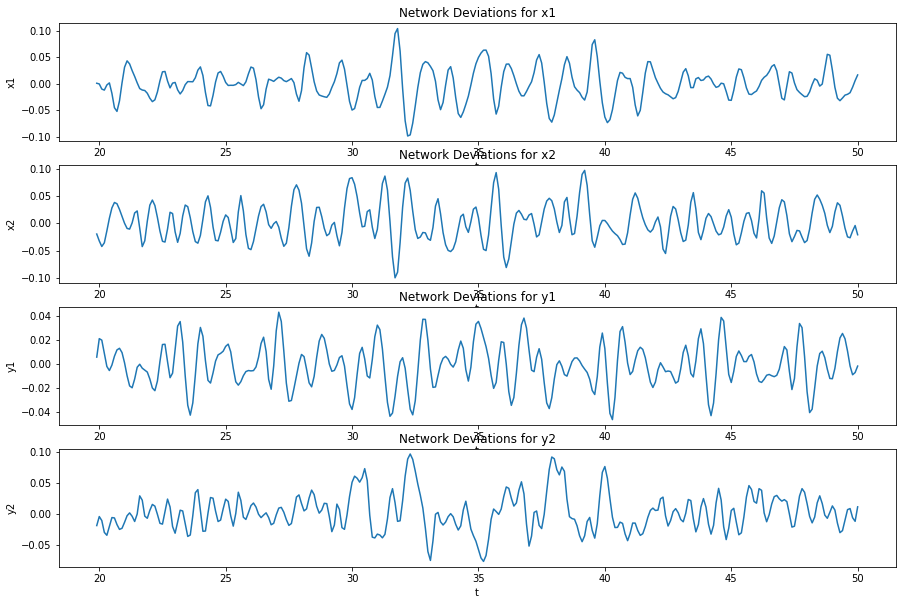

In [18]:
# Plot for deviations 
fig,ax=plt.subplots(4,1, figsize=(15,10))

# Deviation subplot for x1 over time
ax[0].plot(t[windowsize1+offset1-1:],x1_hat2-x1[windowsize1+offset1-1:])
ax[0].set_xlabel("t")
ax[0].set_ylabel("x1")
ax[0].set_title("Network Deviations for x1")

# Deviation subplot for x2 over time
ax[1].plot(t[windowsize1+offset1-1:],x2_hat2-x2[windowsize1+offset1-1:])
ax[1].set_xlabel("t")
ax[1].set_ylabel("x2")
ax[1].set_title("Network Deviations for x2")

# Deviation subplot for y1 over time
ax[2].plot(t[windowsize1+offset1-1:],y1_hat2-y1[windowsize1+offset1-1:])
ax[2].set_xlabel("t")
ax[2].set_ylabel("y1")
ax[2].set_title("Network Deviations for y1")

# Deviation subplot for y2 over time
ax[3].plot(t[windowsize1+offset1-1:],y2_hat2-y2[windowsize1+offset1-1:])
ax[3].set_xlabel("t")
ax[3].set_ylabel("y2")
ax[3].set_title("Network Deviations for y2")

# Adjust spacing
plt.subplots_adjust(hspace = 0.7)

plt.show()

### Comment:
- Increasing the offset we see the model then becomes much better at extrapolating the future behaviour from the initial time window as it has a larger period of motion to correlate and can determining the nature of the motion more effectively; this is evident from the relatively low deviations of the data, we can see in the overlayed plot it has successfully recovered a good approximation of the systems motion.

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:29<00:00, 13.43it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:29<00:00, 13.37it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 14.91it/s]


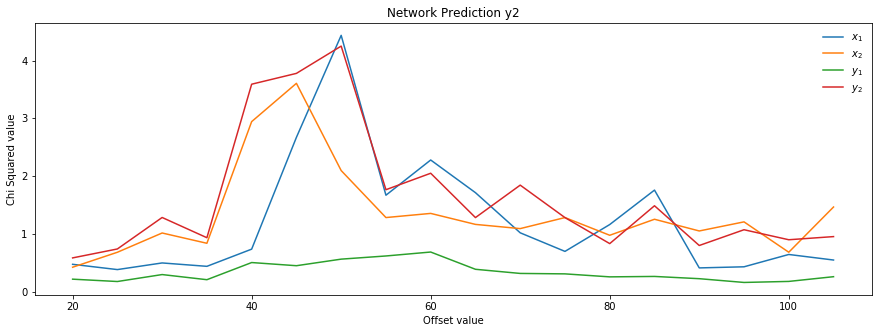

In [19]:
# Range of offsets 
offsets1 = np.arange(20,110,5)

# Calculating chi squared for various offsets 
chi_sq = chi(model, predict_motion, x1, y1, x2, y2, windowsize1, offsets1)

# Plotting chi squared
chi_plot(offsets1, chi_sq)

### Comment:
- Further supporting the above we see as we vary the offset of the model we get the general trend of the chi squared shows the trend of decreasing, this shows with greater ofset the network gets closer to the true solution and is performing better.

## Part 4: 
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.

In [20]:
# Setting new initial angles
Z0=[np.pi/2,0,np.pi/2,0]

# Producing new coordinate arrays
(X1,Y1,X2,Y2), t = motion(Z0, t0, tmax, dt)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:29<00:00, 13.59it/s]


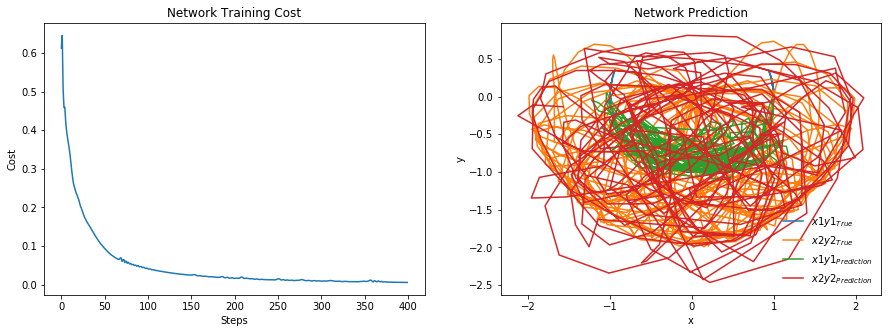

Final cost is 0.0054383729584515095


In [21]:
# Number of samples we will use to train our network
windowsize2= 100

# How many samples into the future to predict
offset2 = 20

# Number of training steps
steps = 400  

# Predicts future motion using function
costs3, (X1_hat, Y1_hat, X2_hat, Y2_hat) = predict_motion(model, X1, Y1, X2, Y2, steps, windowsize2, offset2)

# Plot future trajectories and cost
cost_plot(costs3, steps, X1, Y1, X2, Y2, X1_hat, Y1_hat, X2_hat, Y2_hat)
print('Final cost is',costs3[-1])

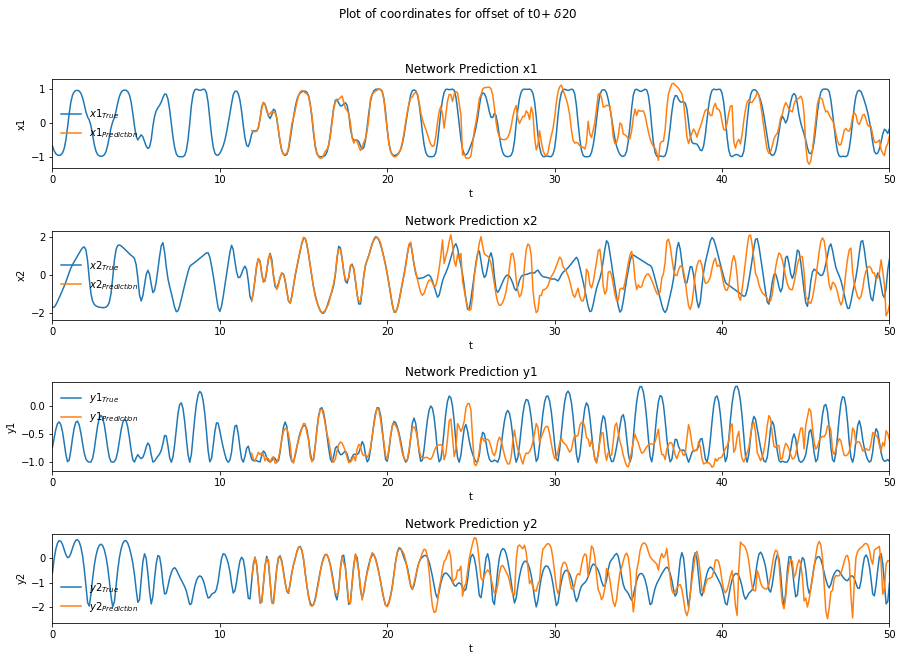

In [22]:
# Set plot limits 
xlims = (0,50)

# Plot motion of each coordinate in time
motion_plot(X1, Y1, X2, Y2, X1_hat, Y1_hat, X2_hat, Y2_hat, t, windowsize2, offset2, xlims)    

### Comment:
- We see with thess more difficuilt initial conditions the networks are much more difficult to predict, within the window of $t_0$ we get good accuracy, however, as the motion beyond this is chaotic the model cannot use this to predict further and deviates greaty 

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  9.60it/s]


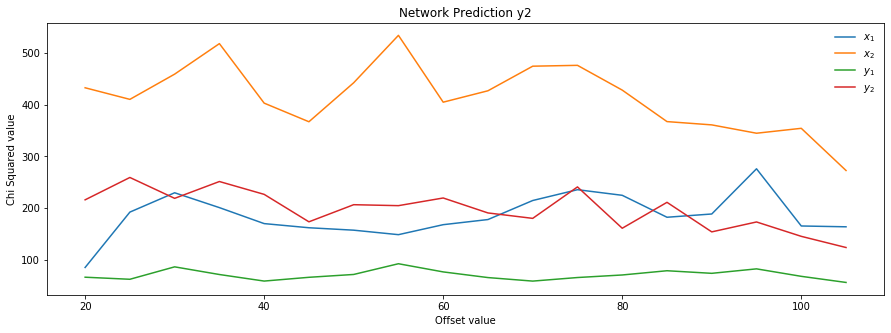

In [23]:
# Range of offsets 
offsets2 = np.arange(20,110,5)

# Calculating chi squared for various offsets 
chi_sq2 = chi(model, predict_motion, X1, Y1, X2, Y2, windowsize2, offsets2)

# Plotting chi squared
chi_plot(offsets2, chi_sq2)

### Comment:
- We see from the variation of chi that due to the chaotic motion its performance does not improve over diferent offset and just oscilates over large values

## Part 5
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)

In [24]:
def predict_motion2(model, x1, y1, x2, y2, steps, windowsize, offset):
    '''New function to predict motion only using 2nd mass coordinates'''
    
    # Compile given model to ensure model is untrained
    model.compile(loss='mean_squared_error',optimizer='adam')
    
    # Stack coordinates such that we have an array of the coordinate of all coordinates at each time step
    xy = np.stack((x1,y1,x2,y2), axis = 1)
    
    # Reshape the data into (batchsize, timesteps, data)
    xyInput, xyLabel = shapeArray(xy, windowsize, offset)
    
    # Create training sample only including up to t0( windowsize*dt) and only taking last  two coordinnates x2,y2
    xyTrain  = xyInput[:windowsize,:,2:]
    
    # Create training target only including up to t0( windowsize*dt), and last time step in label batch
    xyTarget = xyLabel[:windowsize,-1]

    # Array for plotting cost
    costs = np.zeros(steps)  
    
    for i in tqdm(range(steps)):   
        # Train the network on batches
        costs[i] = model.train_on_batch( xyTrain, xyTarget ) 
    
    # Test data includes whole data range beyond window size, only using last two coordinates
    xyTest = xyInput[:,:,2:]
    
    # Predicts futures using Test data
    xy_hat = model.predict_on_batch(xyTest)
    
    # Retrieve predicted coordinates from predicted array
    x1_hat, y1_hat = xy_hat[:,0], xy_hat[:,1]
    x2_hat, y2_hat = xy_hat[:,2], xy_hat[:,3]
    
    return costs, (x1_hat, y1_hat, x2_hat, y2_hat)

In [25]:
# Define new model to  predict only using mass 2

# Define model with LSTM layer of 50, with 4 cartesian coordinate input and output 
model2=keras.models.Sequential()
model2.add(keras.layers.LSTM(50, input_shape=(None,2),return_sequences=False)) # LSTM layer with 50 neurons
model2.add(keras.layers.Dense(4, activation="linear"))

# Compiling the model
model2.compile(loss='mean_squared_error',optimizer='adam')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 10,804
Trainable params: 10,804
Non-trainable params: 0
_________________________________________________________________


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.55it/s]


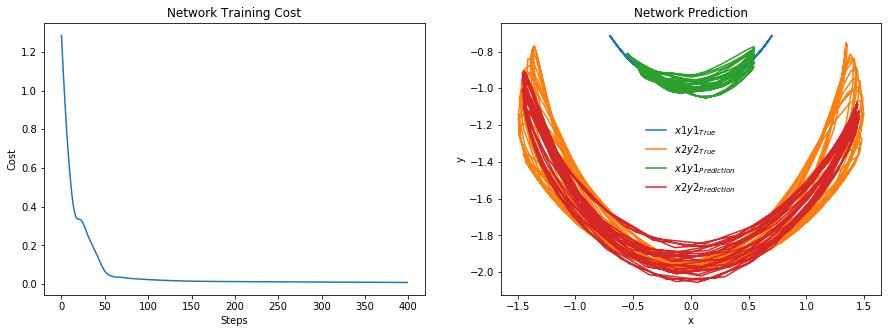

Final cost is 0.008508466184139252


In [26]:
# Number of samples we will use to train our network
windowsize3= 100

# How many samples into the future to predict
offset3= 20

# Number of training steps
steps = 400    

# Predicts using new model for 20 offset
costs4, (x1_hat3, y1_hat3, x2_hat3, y2_hat3) = predict_motion2(model2, x1, y1, x2, y2, steps, windowsize3, offset3)

# Plot future trajectories and cost
cost_plot(costs4, steps, x1, y1, x2, y2, x1_hat3, y1_hat3, x2_hat3, y2_hat3)
print('Final cost is',costs4[-1])

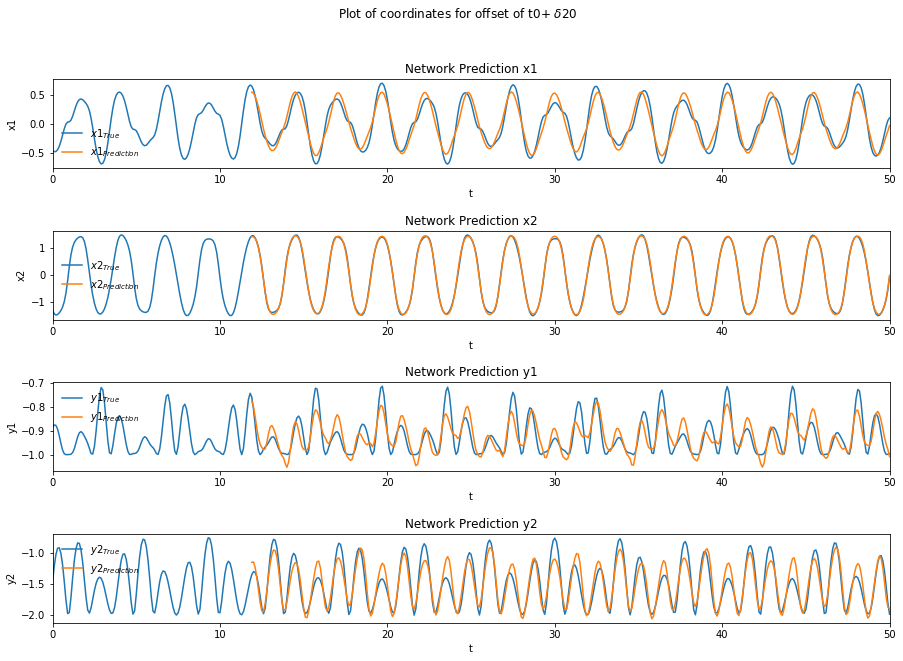

In [27]:
#Set graph limits
xlims = (0,50)

# Plot coordinate motion
motion_plot(x1, y1, x2, y2, x1_hat3, y1_hat3, x2_hat3, y2_hat3, t, windowsize3, offset3, xlims)    

### Comment:
- We see the model accurately predict m2 mass as it has its change in motion explicitly, the model has less accuracy for m1 as the motion is implicit but still has good sucess uncovering the underlying motion

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  9.35it/s]


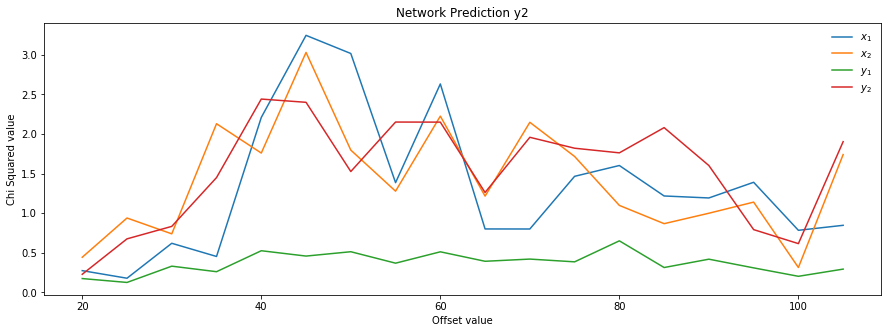

In [28]:
# Range of offsets 
offsets3 = np.arange(20,110,5)

# Calculating chi squared for various offsets 
chi_sq3 = chi(model2, predict_motion2, x1, y1, x2, y2, windowsize3, offsets3)

# Plotting chi squared
chi_plot(offsets3, chi_sq3)

### Comment:
- We see the ssystem is still doing well at reducing the chi squared, with greater deviation for m1 values as this are implicit to the system, we have similar shape as before with greater deviation in the middle

### Single mass other z0

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  9.12it/s]


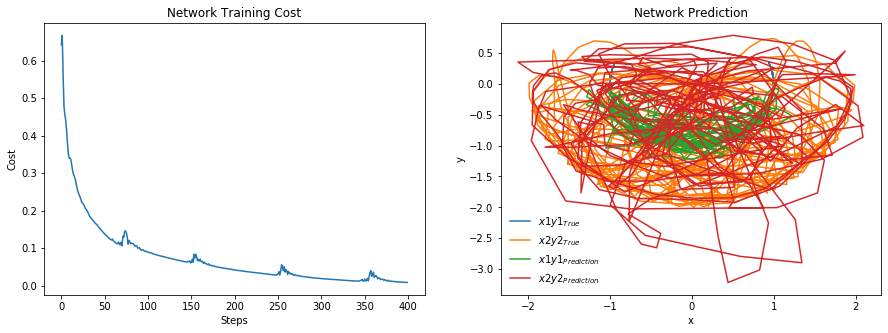

Final cost is 0.00900192465633154


In [29]:
# Number of samples we will use to train our network
windowsize4= 100

# How many samples into the future to predict
offset4 = 20

# Number of training steps
steps = 400  

# Predicts using model future trajectories
costs5, (X1_hat2, Y1_hat2, X2_hat2, Y2_hat2) = predict_motion2(model2, X1, Y1, X2, Y2, steps, windowsize4, offset4)

# Plot future trajectories and cost
cost_plot(costs5, steps, X1, Y1, X2, Y2, X1_hat2, Y1_hat2, X2_hat, Y2_hat2)
print('Final cost is',costs5[-1])

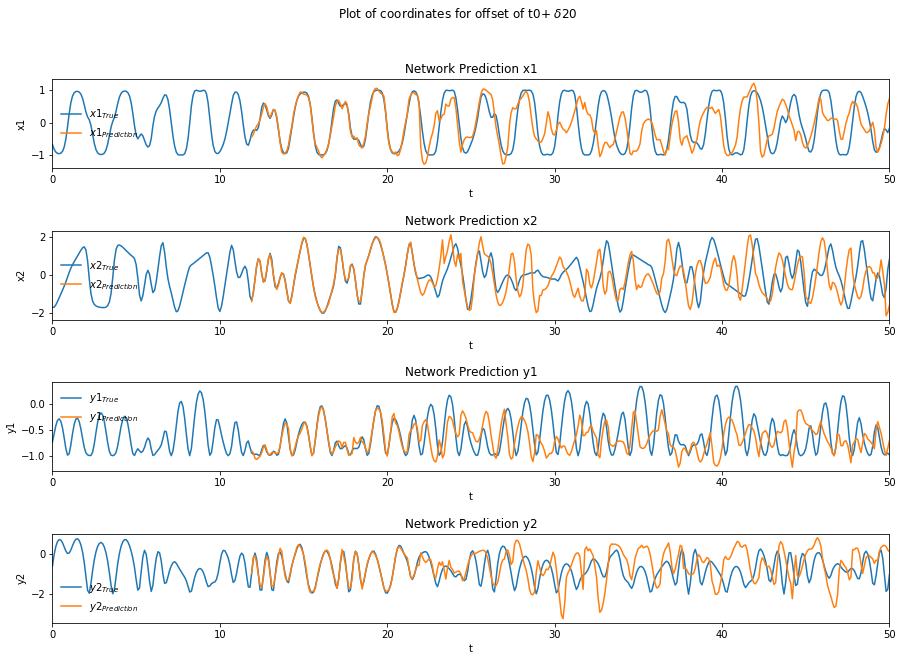

In [30]:
#Set graph limits
xlims = (0,50)

# Plot coordinate motion
motion_plot(X1, Y1, X2, Y2, X1_hat2, Y1_hat2, X2_hat, Y2_hat2, t, windowsize4, offset4, xlims)     

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:26<00:00, 14.86it/s]


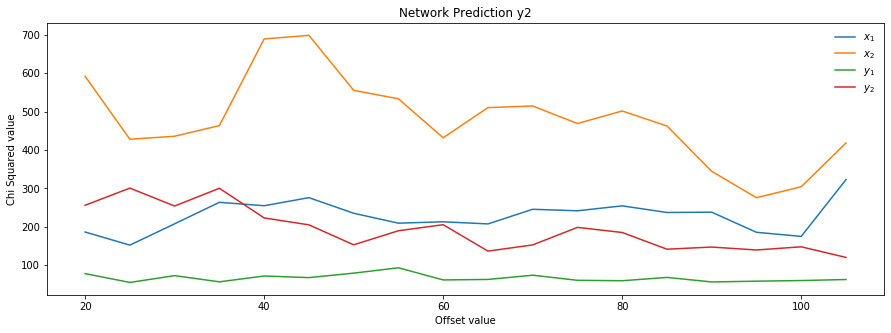

In [31]:
# Range of offsets 
offsets4 = np.arange(20,110,5)

# Calculating chi squared for various offsets 
chi_sq4 = chi(model2, predict_motion2, X1, Y1, X2, Y2, windowsize4, offsets4)

# Plotting chi squared
chi_plot(offsets4, chi_sq4)

### Comment:
- We see similar trend as the chi for chaotic motion above, with the values not converging, here ther are even more so greatly divergent.